# YANDEX.AFISHA

Project description

As part of the analytical department at Yandex.Afisha. our first task is to help optimize marketing expenses.

We have:
Server logs with data on Yandex.Afisha visits from June 2017 through May 2018
Dump file with all orders for the period
Marketing expenses statistics

We are going to study:
How people use the product
When they start to buy
How much money each customer brings
When they pay off

## Download the data and prepare it for analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mt
from functools import reduce

In [2]:
visits = pd.read_csv('/datasets/visits_log_us.csv')
orders= pd.read_csv('/datasets/orders_log_us.csv')
costs = pd.read_csv('/datasets/costs_us.csv')

### Visits

The visits table (server logs with data on website visits):                                                         
Uid — user's unique identifier                                                                                     
Device — user's device                                                                                             
Start Ts — session start date and time                                                                             
End Ts — session end date and time                                                                                 
Source Id — identifier of the ad source the user came from                                                         

In [3]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 79.3 MB


In [4]:
visits.head(5)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Visits data consists of 5 columns with no missing values.The device column will be changed from object to category, while Start Ts & End TS will be changed from objects to datetime. We'll also be making changes to the columns names.

In [5]:
visits.columns=['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [6]:
visits['device']=visits['device'].astype('category')
visits['start_ts']= pd.to_datetime(visits['start_ts'], format="%Y-%m-%d %H:%M:%S")
visits['end_ts']= pd.to_datetime(visits['end_ts'], format="%Y-%m-%d %H:%M:%S")

In [7]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  category      
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


These changes have decreased our memory usage from 79.3MB to 11.3MB

### Orders

The orders table (data on orders):                                                                                 
Uid — unique identifier of the user making an order                                                                 
Buy Ts — order date and time                                                                                       
Revenue — Yandex.Afisha's revenue from the order                                                                   

In [8]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 4.4 MB


In [9]:
orders.head(5)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Orders consists of 3 columns without any missing values. The buy ts colum will be changed from object to datetime. Just as we did in visits, we'll be fixing the columns in this table.

In [10]:
orders['Buy Ts']= pd.to_datetime(orders['Buy Ts'], format="%Y-%m-%d %H:%M:%S")
orders.columns=['buy_ts', 'revenue', 'uid']

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


The changes have decreased our memoragy usage from 4.4MB to 1.2MB 

### Costs

The costs table (data on marketing expenses):                                                                       
source_id — ad source identifier                                                                                    dt — date                                                                                                           
costs — expenses on this ad source on this day

In [12]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Just as the  orders table, costs consists of three columns. No major changes will be made to the data other than converting dt column to datetime format.

In [13]:
costs.head(5)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [14]:
costs['dt']= pd.to_datetime(costs['dt'], format="%Y-%m-%d %H:%M:%S")

## Make reports and Calculate Metrics

We are going to start by calculating the time metrics of users and how often they used the site, how long they stay on a session and move to the other. We will start this process by adding year, month, week and date columns derived from the sessions start date and time. 

### Product

In [15]:
## How many people use it everyday, week, and month?
visits['session_year']  = visits['start_ts'].dt.isocalendar().year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.isocalendar().week
visits['session_date'] = visits['start_ts'].dt.date

In [16]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_total = (visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean())

print('count of users everyday:',int(dau_total))
print('count of users weekly:',int(wau_total))
print('count of users monthly:',int(mau_total))

count of users everyday: 907
count of users weekly: 5716
count of users monthly: 23228


In [17]:
## How many sessions are there per day?
sessions_per_day= visits.groupby('session_date').agg({'uid': 'count'}).mean()
print('Total amount of sessions per day:', int(sessions_per_day));

Total amount of sessions per day: 987


In [18]:
dau_total_session = visits.groupby('session_date').agg({'uid': 'nunique'}).reset_index()
dau_total_session.columns= ['session_date', 'visits']
dau_total_session.head()

,session_date,visits
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820


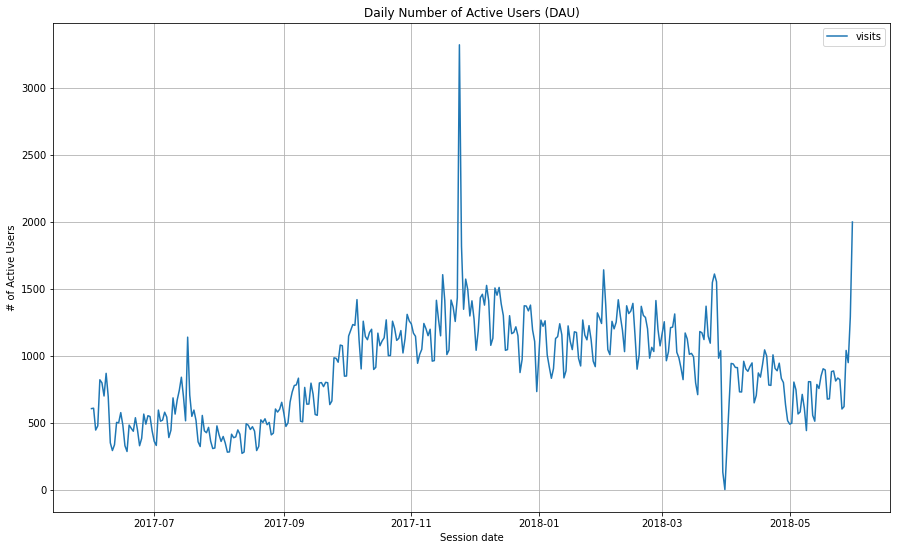

In [19]:
dau_total_session.plot(x='session_date', y='visits', grid=True, figsize=(15,9))
plt.xlabel('Session date')
plt.title('Daily Number of Active Users (DAU)')
plt.ylabel('# of Active Users');

In [20]:
## Sessions Per User
daily_sessions= visits.groupby('session_date').agg({'uid': 'count'}).reset_index()
daily_sessions.columns=['date', 'sessions']
daily_sessions.head()

,date,sessions
0,2017-06-01,664
1,2017-06-02,658
2,2017-06-03,477
3,2017-06-04,510
4,2017-06-05,893


In [21]:
session_per_user = pd.merge(dau_total_session, daily_sessions, how='inner', left_on='session_date', right_on='date')
session_per_user.head()

,session_date,visits,date,sessions
0,2017-06-01,605,2017-06-01,664
1,2017-06-02,608,2017-06-02,658
2,2017-06-03,445,2017-06-03,477
3,2017-06-04,476,2017-06-04,510
4,2017-06-05,820,2017-06-05,893


In [22]:
session_per_user['per_user']= session_per_user['sessions'] / session_per_user['visits']
session_per_user.head()

,session_date,visits,date,sessions,per_user
0,2017-06-01,605,2017-06-01,664,1.097521
1,2017-06-02,608,2017-06-02,658,1.082237
2,2017-06-03,445,2017-06-03,477,1.071910
3,2017-06-04,476,2017-06-04,510,1.071429
4,2017-06-05,820,2017-06-05,893,1.089024


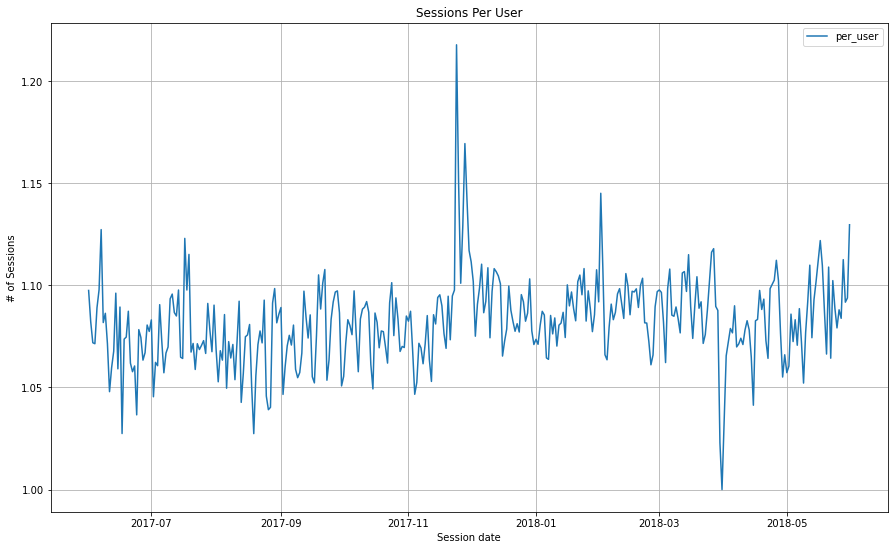

In [23]:
session_per_user.plot(x='session_date', y='per_user',kind='line', grid=True, figsize=(15,9))
plt.xlabel('Session date')
plt.title('Sessions Per User')
plt.ylabel('# of Sessions');

In [24]:
print('The average session per user is:',session_per_user['per_user'].mean().round(2));

The average session per user is: 1.08


In [25]:
wau_total_session = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).reset_index()
wau_total_session.columns=['session_year','session_week', 'visits']
wau_total_session.head()

,session_year,session_week,visits
0,2017,22,2021
1,2017,23,4129
2,2017,24,2812
3,2017,25,2878
4,2017,26,3064


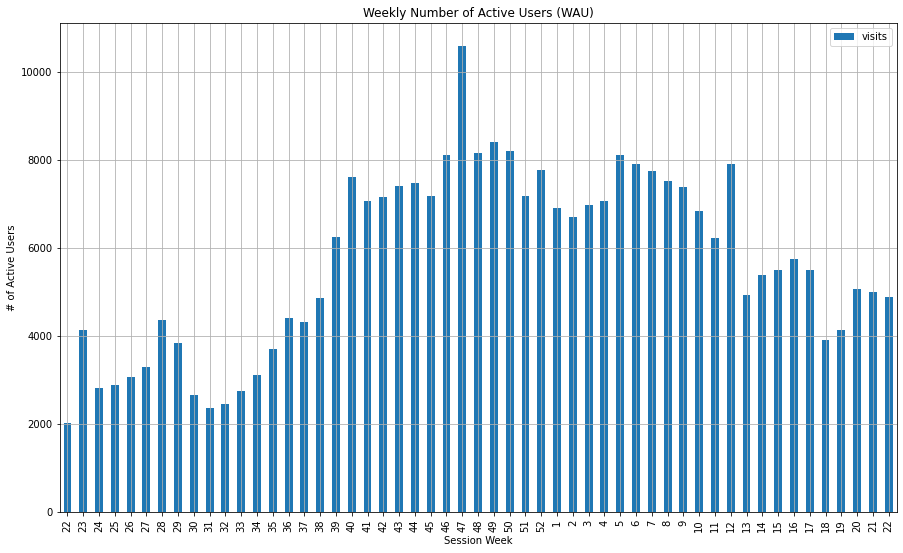

In [26]:
wau_total_session.plot(x='session_week', y='visits',kind='bar', grid=True, figsize=(15,9))
plt.xlabel('Session Week')
plt.title('Weekly Number of Active Users (WAU)')
plt.ylabel('# of Active Users');

In [27]:
mau_total_session = (visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).reset_index())
mau_total_session.columns=['session_year','session_month', 'visits']
mau_total_session.head(15)

,session_year,session_month,visits
0,2017,6,13259
1,2017,7,14183
2,2017,8,11631
3,2017,9,18975
4,2017,10,29692
5,2017,11,32797
6,2017,12,31557
7,2018,1,28716
8,2018,2,28749
9,2018,3,27473


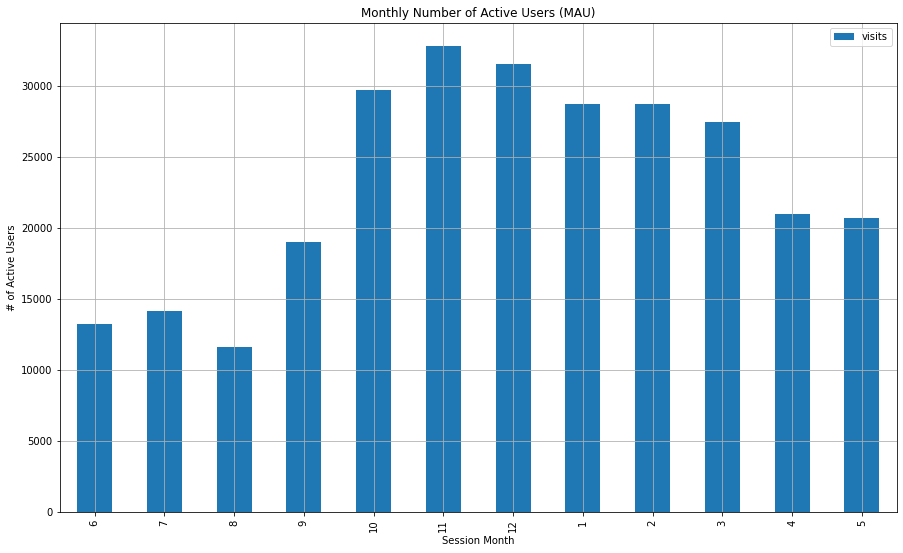

In [28]:
mau_total_session.plot(x='session_month', y='visits',kind='bar', grid=True, figsize=(15,9))
plt.xlabel('Session Month')
plt.title('Monthly Number of Active Users (MAU)')
plt.ylabel('# of Active Users');

<AxesSubplot:>

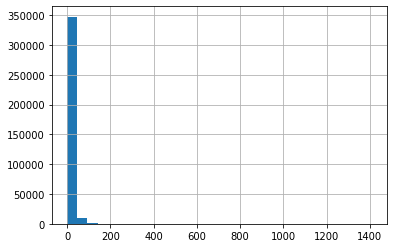

In [29]:
## What is the lenght of each session?
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds/60
visits['session_duration_sec'].hist(bins=30)

The sessions are not evenly distributed. To find the average lenght of the session we will be usind the mode instead of the mean.

In [30]:
asl=int(visits['session_duration_sec'].mode())
print('The average lenght of each session is', int(asl), 'minute.')

The average lenght of each session is 1 minute.


In [31]:
## What's the user retention rate?
first_activity_date = visits.groupby('uid')['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.merge(first_activity_date, on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,18.0,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,28.0,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0.0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,24.0,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,28.0,2018-03-09 20:05:00


In [32]:
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = (visits['cohort_lifetime'] / np.timedelta64(1,'M')).round().astype('int')
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on=['first_activity_month'])
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


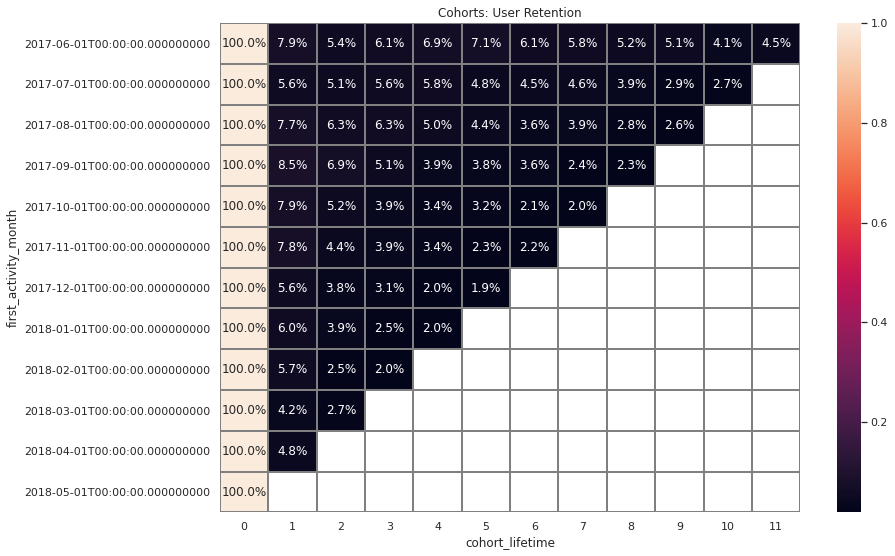

In [33]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='grey');

In [34]:
## Sticky Factor
sticky_wau= (dau_total/wau_total)*100
sticky_mau= (dau_total/mau_total)*100
print('Sticky WAU:',int(sticky_wau),'%');
print('Sticky MAU:',int(sticky_mau),'%');

Sticky WAU: 15 %
Sticky MAU: 3 %


Between the period of June 2017 through May 2018 Yandex.Afisha has an average of 907 daily active users, 5716 monthly users and 23228 yearly users. When looking at the DAU plot, we can see that activity is at its peak during November 2017 and drastically decreases right before January 2018. The trends remains stable for a few months and decreases during the beginning of spring. When looking at weekly data we see that the numbers of weekly visits ranged between 6000-8000 during week 40 -12 week. Respective dates are Oct 1,2017- March 18,2018 with its highest weekly visitors of well above 10000 on week 47 (November 19, 2017).
It looks like our users on average spend a minute from starting and ending their session. Overall, the retention rate drops for each cohort. 15% of its users return weekly whole only 3% return every month.

### Sales

In KPI analysis, we're usually interested in knowing the time that elapses between registration and conversion — when the user becomes a customer. For example, if registration and the first purchase occur on the same day, the user might fall into category Conversion 0d. If the first purchase happens the next day, it will be Conversion 1d. You can use any approach that lets you compare the conversions of different cohorts, so that you can determine which cohort, or marketing channel, is most effective

In [35]:
## When do people start buying?
first_order_date = orders.groupby('uid')['buy_ts'].min().reset_index()
first_order_date.columns=['uid','first_order_date']
orders=orders.merge(first_order_date , on='uid')
orders.head()

,buy_ts,revenue,uid,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


In [36]:
activity_date= visits.groupby('uid')['start_ts'].min().reset_index()
activity_date.columns=['uid','activity_date']
purchase_by_customer=pd.merge(first_order_date, activity_date, how='left', on='uid')
purchase_by_customer['first_sale']= (purchase_by_customer['first_order_date']-purchase_by_customer['activity_date']).dt.days

purchase_by_customer['first_sale'].describe()

count    36523.000000
mean        16.729869
std         46.959088
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: first_sale, dtype: float64

In [37]:
purchase_by_customer.head()

,uid,first_order_date,activity_date,first_sale
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0


In [38]:
(purchase_by_customer['first_sale']==0).sum()

26363

In [39]:
(purchase_by_customer['first_sale']==0).mean()*100

72.18191276729732

In [40]:
(purchase_by_customer['first_sale']==16).sum()

94

72% of customers make their purchace on the same. 94 customers made their purchase on the 16th day

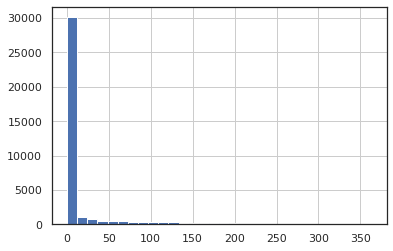

In [41]:
purchase_by_customer['first_sale'].hist(bins=30);

In [42]:
## How many orders do they make during a given period of time?

orders.head()

,buy_ts,revenue,uid,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


In [43]:
orders['order_year']  = orders['buy_ts'].dt.isocalendar().year
orders['order_month'] = orders['buy_ts'].dt.month
orders['order_week']  = orders['buy_ts'].dt.isocalendar().week
orders['order_date'] = orders['buy_ts'].dt.date
orders.head()

,buy_ts,revenue,uid,first_order_date,order_year,order_month,order_week,order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017,6,22,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017,6,22,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017,6,22,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017,6,22,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017,6,22,2017-06-01


In [44]:
daily_orders=orders.groupby('order_date')['uid'].count().mean()
weekly_orders=orders.groupby(['order_month','order_week'])['uid'].count().mean()
monthly_orders=orders.groupby(['order_year','order_month'])['uid'].count().mean()
yearly_orders=orders.groupby('order_year')['uid'].count().mean()

print('avg orders per day:',int(daily_orders))
print('avg orders per week:',int(weekly_orders))
print('avg orders per month:',int(monthly_orders))
print('Average yearly orders:',int(yearly_orders))

avg orders per day: 138
avg orders per week: 813
avg orders per month: 3878
Average yearly orders: 25207


In [45]:
purchase_by_customer.head()

,uid,first_order_date,activity_date,first_sale
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0


In [46]:
purchase_by_customer['first_purchase_month']= purchase_by_customer['first_order_date'].astype('datetime64[M]')
purchase_by_customer.head()

,uid,first_order_date,activity_date,first_sale,first_purchase_month
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0,2017-06-01
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,0,2017-10-01
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,0,2018-01-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0,2017-11-01


In [47]:
order_cohort_size= purchase_by_customer.groupby('first_purchase_month').agg({'uid': 'nunique'}).reset_index()
order_cohort_size.columns= ['first_purchase_month','n_buyer']
order_cohort_size.head()

,first_purchase_month,n_buyer
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [48]:
orders.head()

,buy_ts,revenue,uid,first_order_date,order_year,order_month,order_week,order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017,6,22,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017,6,22,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017,6,22,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017,6,22,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017,6,22,2017-06-01


In [49]:
first_order_date_by_customers = orders.groupby('uid')['order_date'].min().reset_index()
first_order_date_by_customers.columns = ['uid','first_purchase']
first_order_date_by_customers.head()

,uid,first_purchase
0,313578113262317,2018-01-03
1,1575281904278712,2017-06-03
2,2429014661409475,2017-10-11
3,2464366381792757,2018-01-28
4,2551852515556206,2017-11-24


In [50]:
first_orders= orders.merge(first_order_date_by_customers, on='uid')
first_orders['month']= first_orders['order_date'].astype('datetime64[M]')
first_orders.head()

,buy_ts,revenue,uid,first_order_date,order_year,order_month,order_week,order_date,first_purchase,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01


In [51]:
first_orders1= first_orders.merge(purchase_by_customer,on='uid')
first_orders.head()

,buy_ts,revenue,uid,first_order_date,order_year,order_month,order_week,order_date,first_purchase,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01


In [52]:
cohort_order= first_orders1.groupby(['first_purchase_month', 'month']).agg({'uid':'count'}).reset_index()
cohort_order.columns=['first_purchase_month','month', 'purchases']
cohort_order.head()

,first_purchase_month,month,purchases
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292


In [53]:
cohort_order= cohort_order.merge(order_cohort_size, on='first_purchase_month')
cohort_order['age']=(cohort_order['month']-cohort_order['first_purchase_month'])/ np.timedelta64(1, 'M')
cohort_order['age']=cohort_order['age'].round()
cohort_order['per_buyer']=cohort_order['purchases']/cohort_order['n_buyer']
cohort_order.head()

,first_purchase_month,month,purchases,n_buyer,age,per_buyer
0,2017-06-01,2017-06-01,2354,2023,0.0,1.163618
1,2017-06-01,2017-07-01,177,2023,1.0,0.087494
2,2017-06-01,2017-08-01,174,2023,2.0,0.086011
3,2017-06-01,2017-09-01,226,2023,3.0,0.111715
4,2017-06-01,2017-10-01,292,2023,4.0,0.144340


In [54]:
cohort_order_pivot = cohort_order.pivot_table(index = 'first_purchase_month',columns = 'age',values = 'per_buyer',aggfunc = 'sum').round(2).cumsum(axis=1)
cohort_order_pivot

age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_purchase_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.70,1.84,1.93,2.03,2.11,2.16,2.2
2017-07-01,1.14,1.19,1.25,1.30,1.34,1.38,1.41,1.44,1.47,1.48,1.51,NaN
2017-08-01,1.12,1.20,1.27,1.33,1.39,1.44,1.48,1.54,1.57,1.60,NaN,NaN
2017-09-01,1.14,1.22,1.28,1.34,1.37,1.41,1.45,1.47,1.49,NaN,NaN,NaN
2017-10-01,1.14,1.21,1.25,1.28,1.31,1.33,1.35,1.38,NaN,NaN,NaN,NaN
2017-11-01,1.18,1.28,1.32,1.37,1.40,1.41,1.43,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.15,1.21,1.26,1.30,1.32,1.34,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.12,1.19,1.24,1.26,1.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.12,1.18,1.20,1.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


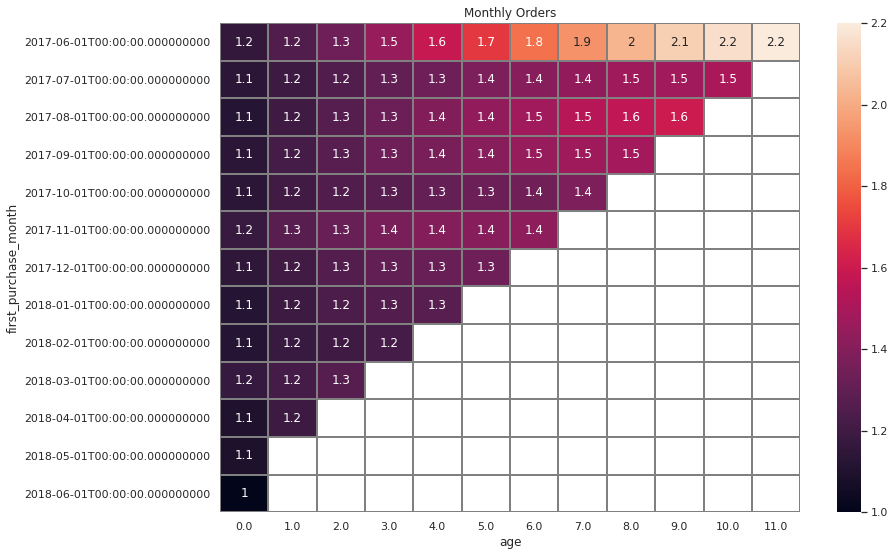

In [55]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Monthly Orders')
sns.heatmap(cohort_order_pivot, annot=True, linewidths=1, linecolor='grey');

By age 4 June cohort is in the lead in terms orders made per buyer.

In [56]:
## What is the average purchase size?
total_rev= orders['revenue'].sum().round()
avg_rev= orders['revenue'].mean().round()
print('Total Afisha Revenue:', total_rev)
print('Avg Afisha Revenue:', avg_rev)

Total Afisha Revenue: 252057.0
Avg Afisha Revenue: 5.0


In [57]:
first_orders.head()

,buy_ts,revenue,uid,first_order_date,order_year,order_month,order_week,order_date,first_purchase,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017,6,22,2017-06-01,2017-06-01,2017-06-01


In [58]:
monthly_revenue=orders.groupby(['order_year','order_month']).agg({'revenue':'mean'}).reset_index()
monthly_revenue.head()

,order_year,order_month,revenue
0,2017,6,4.060106
1,2017,7,5.306589
2,2017,8,4.847139
3,2017,9,5.416448
4,2017,10,4.928280


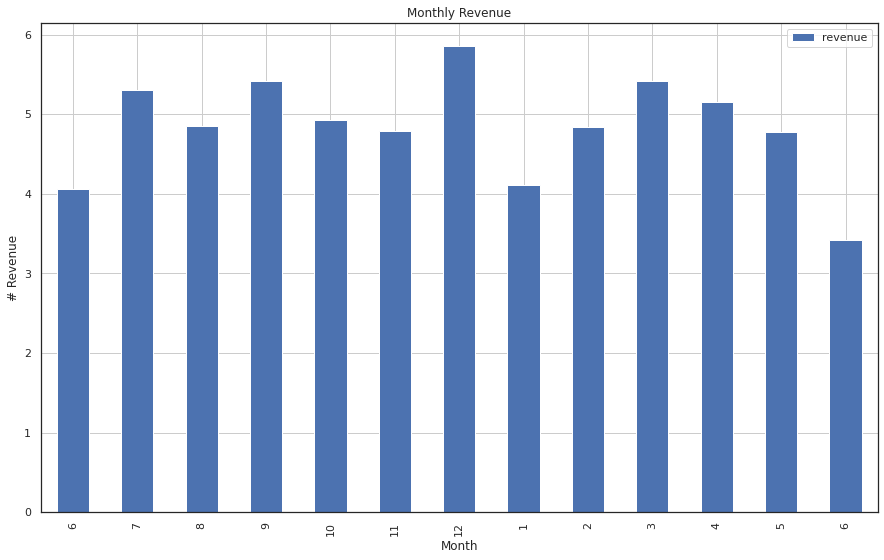

In [59]:
monthly_revenue.plot(x='order_month', y='revenue',kind='bar', grid=True, figsize=(15,9))
plt.xlabel('Month')
plt.title('Monthly Revenue')
plt.ylabel('# Revenue');

December experience the highest revenue.

In [60]:
## How much money do they bring? (LTV)
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,first_order_date,order_year,order_month,order_week,order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017,2017-06-01,22,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017,2017-06-01,22,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017,2017-06-01,22,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017,2017-06-01,22,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017,2017-06-01,22,2017-06-01


In [61]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
cohort_sizes = (
    first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [62]:
orders_ = pd.merge(first_orders, orders, on='uid')
orders_.head()

,uid,first_order_month,buy_ts,revenue,first_order_date,order_year,order_month,order_week,order_date
0,313578113262317,2018-01-01,2018-01-03 21:51:00,0.55,2018-01-03 21:51:00,2018,2018-01-01,1,2018-01-03
1,1575281904278712,2017-06-01,2017-06-03 10:13:00,1.22,2017-06-03 10:13:00,2017,2017-06-01,22,2017-06-03
2,1575281904278712,2017-06-01,2017-06-03 17:39:00,1.83,2017-06-03 10:13:00,2017,2017-06-01,22,2017-06-03
3,2429014661409475,2017-10-01,2017-10-11 18:33:00,73.33,2017-10-11 18:33:00,2017,2017-10-01,41,2017-10-11
4,2464366381792757,2018-01-01,2018-01-28 15:54:00,2.44,2018-01-28 15:54:00,2018,2018-01-01,4,2018-01-28


In [63]:
cohorts= orders_.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum'}).reset_index()
report= pd.merge(cohort_sizes, cohorts, on='first_order_month')
report['age']= (report['order_month']-report['first_order_month'])/ np.timedelta64(1, 'M')
report['age']=report['age'].round().astype('int')
report['ltv'] = report['revenue'] /report['n_buyers']

results=report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='sum').round(2).cumsum(axis=1)
results

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.40,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.37,7.58,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.93,7.00,7.31,7.65,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,4.43,4.73,4.87,4.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,4.44,4.52,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


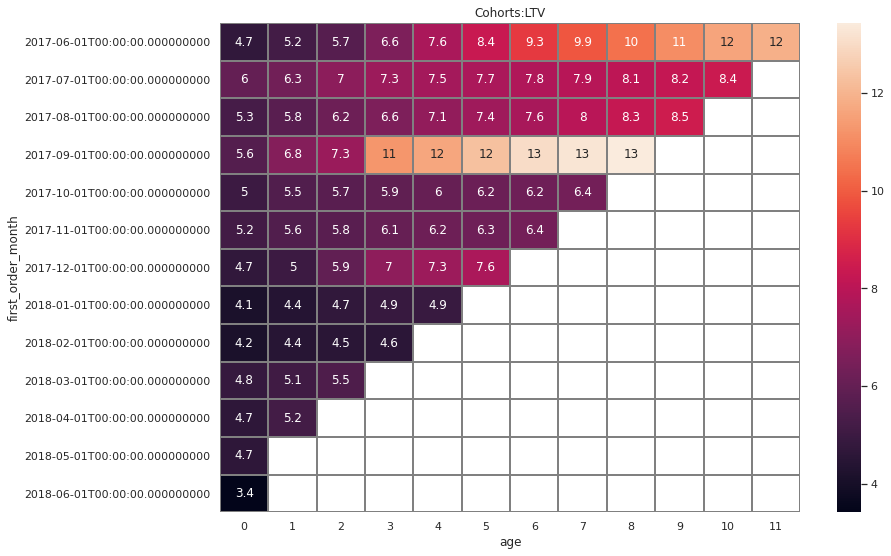

In [64]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts:LTV')
sns.heatmap(results, annot=True, linewidths=1, linecolor='grey');

As stated previously 72% of visitors make a purchase on the same day. On average, 138 order are made daily, 813 weekly,3878 monthly and 25207 yearly. Total revenue is 252,057 with an Averrage of 5. Not exactly sure if this is in millions or billions. 

## Marketing

In [65]:
## How much money was spent? Overall
total_cost= costs['costs'].sum().round()
avg_cost= costs['costs'].mean().round()
print('Total marketing cost:', total_cost)
print('Avg marketing cost:', avg_cost)

Total marketing cost: 329132.0
Avg marketing cost: 129.0


In [66]:
## How much money was spent per source?
cost_per_source= costs.groupby('source_id')['costs'].sum().reset_index()
print('The marketing cost per source:')
print(cost_per_source)

The marketing cost per source:
   source_id      costs
0          1   20833.27
1          2   42806.04
2          3  141321.63
3          4   61073.60
4          5   51757.10
5          9    5517.49
6         10    5822.49


A total of 329,132 was spent on marketing with an average of 129. Source 3 came out to be the most expensive of all, costing Yandex.Afisha 141,321.63 and bringing in 13,846 customers. Source 2 cost about 43% less than source 3 and brought in 1000 more customers.

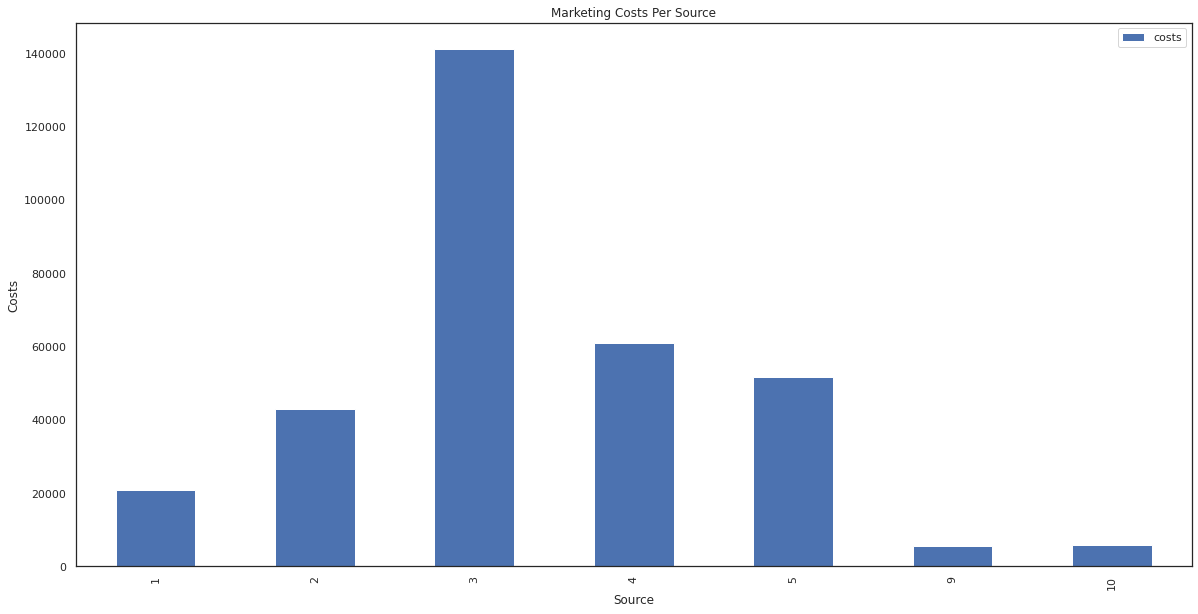

In [67]:
cost_per_source.plot(x='source_id', y='costs', kind='bar', figsize=(20,10))
plt.xlabel('Source')
plt.title('Marketing Costs Per Source')
plt.ylabel('Costs');

In [68]:
costs['cost_month'] = costs.dt.astype('datetime64[M]')

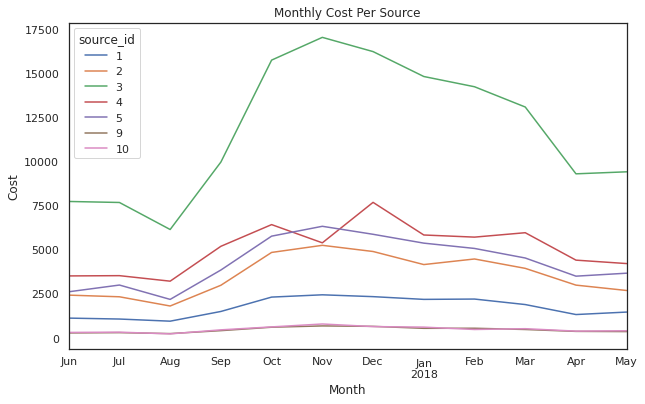

In [69]:
costs.pivot_table(index='cost_month', columns='source_id', values='costs', aggfunc='sum').plot(figsize=(10,6))
plt.xlabel('Month')
plt.ylabel('Cost')
plt.title('Monthly Cost Per Source')
plt.show()

In [70]:
## How much money was spent over time?
monthly_cost = costs.groupby('cost_month')['costs'].sum().reset_index()
monthly_cost.columns = ['month', 'monthly_costs']
monthly_cost.head()

,month,monthly_costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88


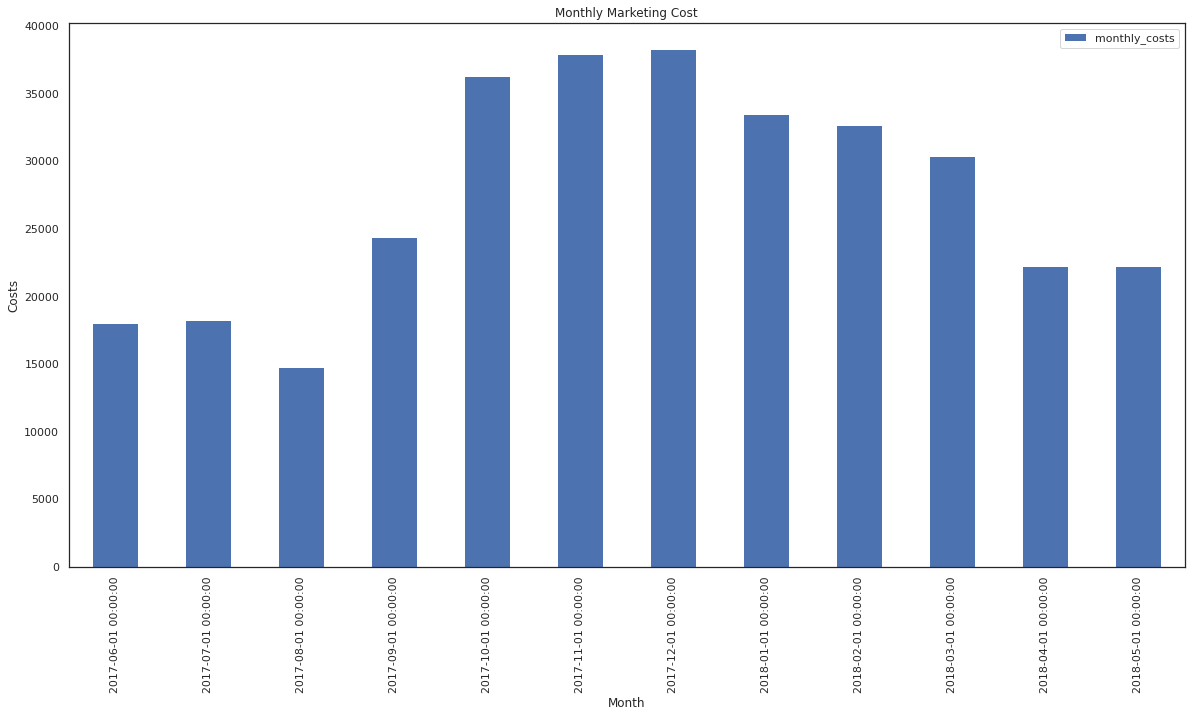

In [71]:
monthly_cost.plot(x='month', y='monthly_costs', kind='bar', figsize=(20,10))
plt.xlabel('Month')
plt.title('Monthly Marketing Cost')
plt.ylabel('Costs');

In [72]:
initial_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
initial_orders.columns = ['uid', 'first_order_month']
marketing_cohort_sizes = initial_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
marketing_cohort_sizes.columns = ['first_order_month', 'n_buyers']
marketing_cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [73]:
orders_marketing = pd.merge(orders,initial_orders, on='uid')
marketing_cohorts = orders_marketing.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
marketing_cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [74]:
reporting = pd.merge(marketing_cohort_sizes, marketing_cohorts, on='first_order_month')
reporting.head() 

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [75]:
reporting['age'] = (reporting['order_month'] - reporting['first_order_month']) / np.timedelta64(1, 'M')
reporting['age'] = reporting['age'].round().astype('int')
reporting['ltv'] = reporting['revenue'] / reporting['n_buyers']
reporting.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531


In [76]:
report_ = pd.merge(reporting, monthly_cost, left_on='first_order_month', right_on='month')
report_['cac'] = report_['monthly_costs'] / report_['n_buyers']
report_.head() 

,first_order_month,n_buyers,order_month,revenue,age,ltv,month,monthly_costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-06-01,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,2017-06-01,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,2017-06-01,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,2017-06-01,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,2017-06-01,18015.0,8.905091


In [77]:
report_['roi'] = report_['ltv'] / report_['cac']
report_.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv,month,monthly_costs,cac,roi
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-06-01,18015.0,8.905091,0.530530
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,2017-06-01,18015.0,8.905091,0.054500
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,2017-06-01,18015.0,8.905091,0.049145
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,2017-06-01,18015.0,8.905091,0.107205
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,2017-06-01,18015.0,8.905091,0.114825


In [78]:
output = report_.pivot_table(index='first_order_month', columns='age', values='roi', aggfunc='mean')
output.cumsum(axis=1).round(2) 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
output_ = report_.pivot_table(index='first_order_month', columns='age', values='roi', aggfunc='mean').round(2).cumsum(axis=1)
output_

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.58,0.63,0.74,0.85,0.93,1.04,1.11,1.17,1.24,1.3,1.33
2017-07-01,0.63,0.67,0.74,0.78,0.80,0.82,0.83,0.84,0.86,0.88,0.9,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.69,0.71,0.75,0.78,0.80,NaN,NaN
2017-09-01,0.60,0.72,0.78,1.20,1.24,1.31,1.38,1.41,1.43,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.73,0.74,0.75,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.59,0.61,0.64,0.66,0.67,0.68,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.88,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


When looking at the pivot_table we can see it usually takes about 6 months for users to pay back.

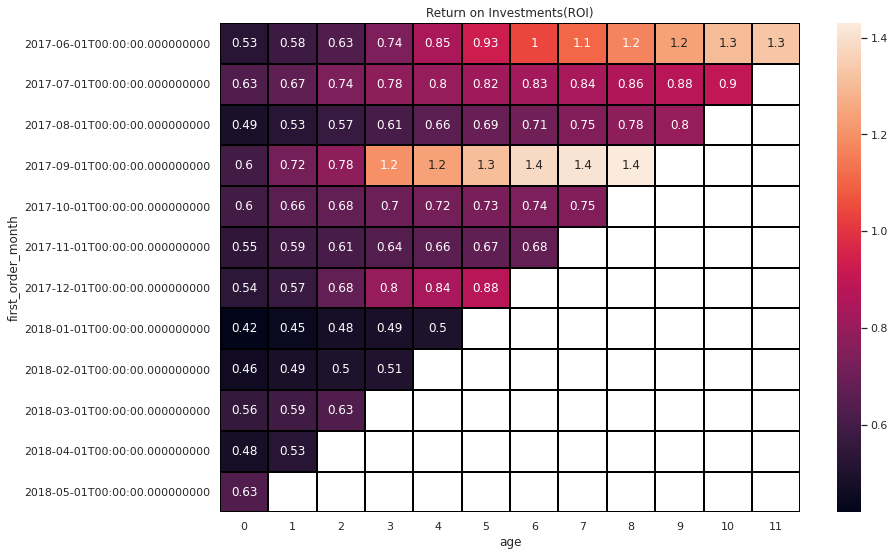

In [80]:
plt.figure(figsize=(13, 9))
plt.title('Return on Investments(ROI)')
sns.heatmap(output_,annot=True,linewidths=1, linecolor='black');

In [81]:
report_.mean()

/tmp/ipykernel_49/1507247696.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  report_.mean()


n_buyers          2840.397436
revenue           3231.458718
age                  3.666667
ltv                  1.120532
monthly_costs    25979.691538
cac                  9.319905
roi                  0.122403
dtype: float64

The average LTV is 1.11                                                
CAC average is 9.3                                                     

In [82]:
costs_cac= costs.groupby('cost_month').agg({'costs':'sum'}).reset_index()
costs_cac.head()

,cost_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88


In [83]:
total_cac= orders_.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
total_cac.head()

,first_order_month,uid
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [84]:
cac_whole_project= costs_cac.merge(total_cac,  left_index=True, right_index=True)
cac_whole_project['cac']=cac_whole_project['costs']/cac_whole_project['uid']
cac_whole_project.head()

,cost_month,costs,first_order_month,uid,cac
0,2017-06-01,18015.00,2017-06-01,2023,8.905091
1,2017-07-01,18240.59,2017-07-01,1923,9.485486
2,2017-08-01,14790.54,2017-08-01,1370,10.796015
3,2017-09-01,24368.91,2017-09-01,2581,9.441654
4,2017-10-01,36322.88,2017-10-01,4340,8.369327


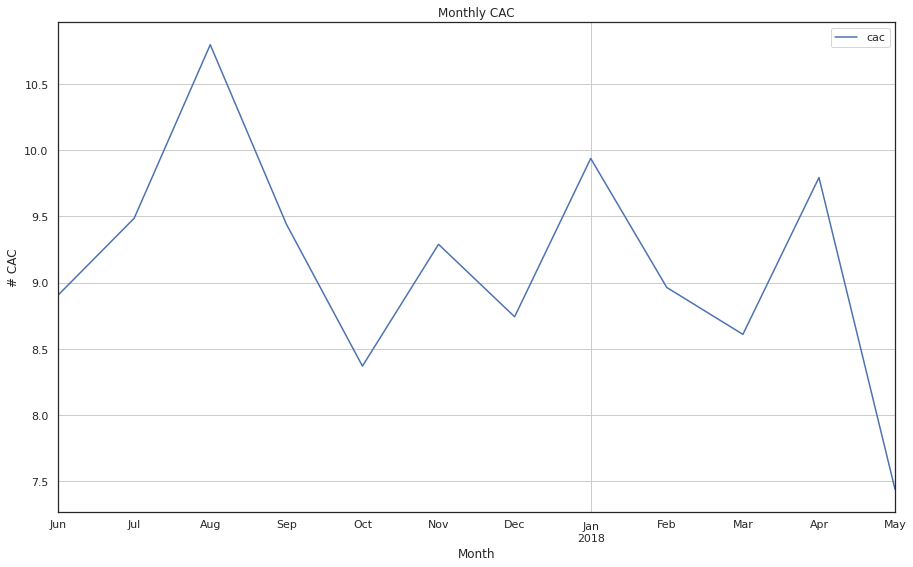

In [85]:
cac_whole_project.plot(x='first_order_month', y='cac',kind='line', grid=True, figsize=(15,9))
plt.xlabel('Month')
plt.title('Monthly CAC')
plt.ylabel('# CAC');

In [86]:
### CAC by source
source_visits= visits.groupby(['source_id','first_activity_month']).agg({'uid':'count'}).reset_index()
source_visits.head()

,source_id,first_activity_month,uid
0,1,2017-06-01,7650
1,1,2017-07-01,2473
2,1,2017-08-01,1700
3,1,2017-09-01,2447
4,1,2017-10-01,3447


In [87]:
cac_source= source_visits.merge(costs,left_on=(['source_id', 'first_activity_month']), right_on=(['source_id', 'dt']))
cac_source['cac']= cac_source['costs']/cac_source['uid']
cac_source.head()

,source_id,first_activity_month,uid,dt,costs,cost_month,cac
0,1,2017-06-01,7650,2017-06-01,75.20,2017-06-01,0.009830
1,1,2017-07-01,2473,2017-07-01,5.80,2017-07-01,0.002345
2,1,2017-08-01,1700,2017-08-01,44.65,2017-08-01,0.026265
3,1,2017-09-01,2447,2017-09-01,40.28,2017-09-01,0.016461
4,1,2017-10-01,3447,2017-10-01,57.14,2017-10-01,0.016577


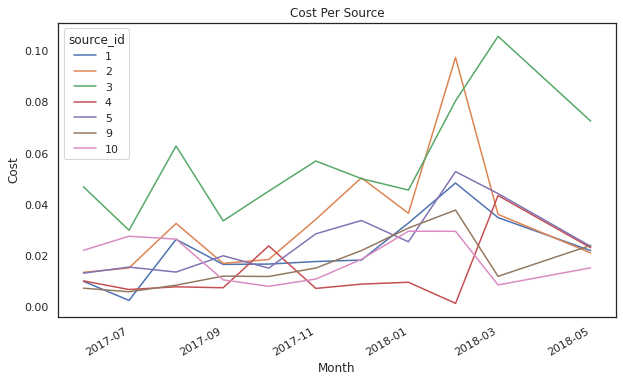

In [88]:
cac_source.pivot_table(index='cost_month', columns='source_id', values='cac', aggfunc='mean').plot(figsize=(10,6))
plt.xlabel('Month')
plt.ylabel('Cost')
plt.title('Cost Per Source')
plt.show()

Source 3 & source 3 are the most expensive  and the cost increases for both in Jan 2018.


In [90]:
users = visits.sort_values('start_ts').groupby('uid').first()
users = users[['source_id']]


In [97]:
#Find the time of the first purchase of each customer 
first_orders = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_ts']
first_orders['first_order_dt'] = first_orders['first_order_ts'].dt.date
first_orders['first_order_month'] = first_orders['first_order_ts'].astype('datetime64[M]')

orders_users = pd.merge(first_orders, users, left_on='uid', right_index=True)

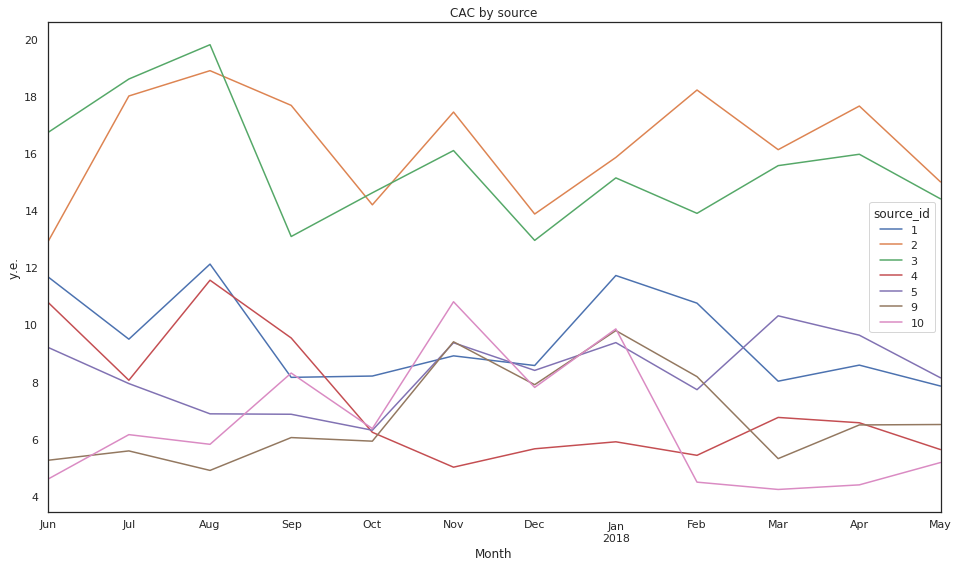

In [100]:
buyers_daily = orders_users.groupby(['source_id', 'first_order_dt']).agg({'uid': 'count'}).reset_index()
buyers_daily.rename(columns={'uid': 'n_buyers'}, inplace=True)
buyers_daily['first_order_dt'] = pd.to_datetime(buyers_daily['first_order_dt'])

costs_ = pd.merge(buyers_daily, costs, left_on=['source_id', 'first_order_dt'], right_on=['source_id', 'dt'])
costs_['costs_per_buyer'] = costs_['costs']/costs_['n_buyers']

costs_.pivot_table(index=['cost_month'], columns='source_id', values='costs_per_buyer', aggfunc='mean').plot(
    figsize=(16,9), title='CAС by source', xlabel = 'Month', ylabel = 'у.е.')
plt.show()

## Conclusions

We have been offered an internship at Yandex.Afisha and are asked to help optimize the marketing expenses. We start by downloading and cleaning our data. We studied the behaviors of visitors and customers and found the folowing:

Between the period of June 2017 through May 2018 Yandex.Afisha has an average of 907 daily active users, 5716 monthly users and 23228 yearly users. When looking at the DAU plot, we can see that activity is at its peak during November 2017 and drastically decreases right before January 2018. The trends remains stable for a few months and decreases during the beginning of spring. When looking at weekly data we see that the numbers of weekly visits ranged between 6000-8000 during week 40 -12 week. Respective dates are Oct 1,2017- March 18,2018 with its highest weekly visitors of well above 10000 on week 47 (November 19, 2017). I would assume this is high due to sales during the holiday season. It looks like our users on average spend a minute from starting and ending their session. Overall, the retention rate drops for each cohort. 15% of its users return weekly whole only 3% return every month.

72% of visitors make a purchase on the same day. On average, 138 orderes were made daily, 813 weekly,3878 monthly and 25207 yearly. Total revenue is 252,057 with an Averrage of 5. Not exactly sure if this is in millions or billions. It seems ROI is paying off within 6 months.

After studying our marketing expenses from each source, we found the following: A total of 329,132 was spent on marketing with an average of 129. Source 3 came out to be the most expensive of all, costing Yandex.Afisha 141,321.63 and bringing in 13,846 customers. Source 4 cost about 43% less than source 3 and brought in 1000 more customers. 

